In [1]:
!pip install ruptures

In [2]:
import pandas as pd
import numpy as np
from TA import *

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
import matplotlib.dates as mdates
%matplotlib inline

from datetime import datetime
import dateutil.parser
import copy

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report,roc_auc_score, make_scorer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin


import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.regularizers import l1, l2
from keras.optimizers import Adam

from sklearn import tree
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler


from vnstock import Vnstock
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

Phiên bản Vnstock 3.2.5 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.3

Phiên bản Vnai 2.0.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.2

In [3]:
import ruptures

In [4]:
def VN_Stock_close_data(start_time,end_time, list_choice = 'VN30', interval = '1D'):
    stock = Vnstock().stock(symbol='ACB', source='VCI')
    stock_list = stock.listing.symbols_by_group(list_choice)

    futures = pd.DataFrame()

    for ma_ck in stock_list:
        try:
            stock = Vnstock().stock(symbol= ma_ck, source='VCI')
            df = stock.quote.history(start= start_time, end= end_time, interval= interval)
            df = df.set_index('time')
            df = pd.DataFrame(df['close'])
            df.columns = [ma_ck]
            df.index = df.index.date
            futures = pd.concat([futures,df],axis = 1, join = 'outer').sort_index()
        except:
            continue

    if interval != '1D':
      futures['Date']= pd.to_datetime(futures.index, format='%Y-%m-%d')
    else:
      futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d %H:%M:%S')
    futures.set_index('Date', inplace=True)

    return futures

In [5]:
start_time = '2017-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

hourly_test = VN_Stock_close_data(start_time, end_time)
hourly_test

,ACB,BCM,BID,BVH,CTG,FPT,GAS,GVR,HDB,HPG,...,TCB,TPB,VCB,VHM,VIB,VIC,VJC,VNM,VPB,VRE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,8.15,NaN,14.90,57.74,16.65,18.33,57.64,NaN,NaN,10.85,...,NaN,NaN,23.41,NaN,3.50,57.44,118.84,105.37,8.73,37.54
2018-01-03,8.13,NaN,14.79,56.73,16.55,18.33,58.91,NaN,NaN,10.82,...,NaN,NaN,23.37,NaN,3.50,59.13,119.49,106.57,8.74,37.58
2018-01-04,8.15,NaN,15.20,57.32,17.15,18.70,61.69,NaN,NaN,10.96,...,NaN,NaN,23.58,NaN,3.53,59.50,119.97,107.02,9.06,37.42
2018-01-05,8.15,NaN,15.12,56.05,16.75,18.39,60.72,NaN,9.78,10.91,...,NaN,NaN,22.98,NaN,3.66,58.77,119.97,106.37,8.96,37.26
2018-01-08,8.42,NaN,15.37,57.07,17.15,18.67,60.72,NaN,9.81,11.25,...,NaN,NaN,23.58,NaN,3.86,58.99,119.65,104.63,9.37,36.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,26.15,74.5,41.10,58.70,41.90,140.50,68.60,32.45,23.45,27.70,...,26.50,15.89,62.54,40.25,20.01,40.60,96.60,61.62,19.03,17.35
2025-02-25,26.00,76.6,41.25,57.20,41.85,139.00,68.70,32.10,23.20,27.50,...,26.40,15.80,61.94,40.75,19.96,40.70,96.10,60.75,18.84,17.25
2025-02-26,25.95,76.4,41.20,57.80,41.35,141.80,68.40,32.60,23.05,27.75,...,26.30,15.80,61.74,40.70,19.82,41.00,97.10,60.94,18.74,17.15


In [6]:
hourly_test['ACB']

Date
2018-01-02     8.15
2018-01-03     8.13
2018-01-04     8.15
2018-01-05     8.15
2018-01-08     8.42
              ...  
2025-02-24    26.15
2025-02-25    26.00
2025-02-26    25.95
2025-02-27    26.10
2025-02-28    26.00
Name: ACB, Length: 1787, dtype: float64

In [7]:
type(np.array(hourly_test['ACB']))

numpy.ndarray

[70, 110, 280, 530, 745, 825, 1000, 1075, 1450, 1625, 1787]


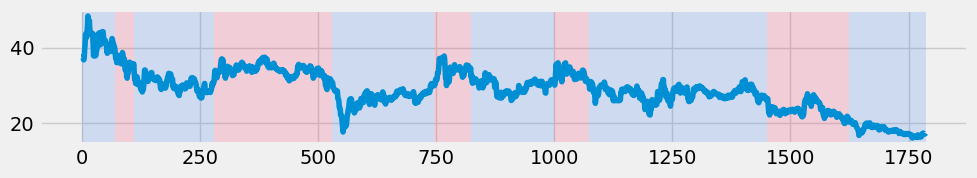

In [ ]:
import matplotlib.pyplot as plt
import ruptures as rpt


# detection
algo = rpt.Dynp(model="rbf").fit(np.array(hourly_test['HPG']))
result = algo.predict(n_bkps = 10)

print(result)

# display
rpt.display(hourly_test['HPG'], result)
plt.show()